We want a test that check if the predicition probability for $\tau$ decay has the same distribution over a real D decay and a monte carlo of a D decay 

In [1]:
import numpy as np
%matplotlib inline
from matplotlib import pylab as plt
import pandas as pd
import evaluation

In [2]:
folder = '../inputs/'

In [3]:
agreement = pd.read_csv(folder + 'check_agreement.csv', index_col='id')

The agreement is made from monte carlo of D decay and real data which is made from both signal and background of D decay

In [4]:
agreement_mc = agreement[agreement.signal == 1]
agreement_real = agreement[agreement.signal == 0]

We want to take our control $x$, which is in our case the predicition probability for $\tau \rightarrow \mu \mu \mu$ decay, and accumulate it in to two histogram one for real D decay and one for simulated D decay.

For the `agreement_mc` we know that all events are signal and we should use the same weight for all of them when building the histogram. Therefore they all have the same weight.

In [5]:
assert np.all(agreement_mc.weight == 1);

But we dont know exactly which real events are D decay and which are background. Instead we will use a different weight for each event.
High value indicates a D decay and low value a background.

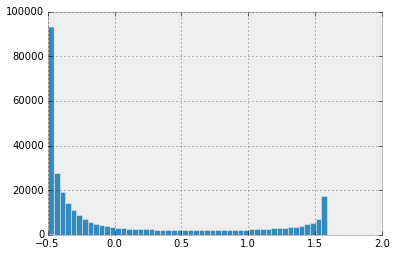

In [6]:
agreement_real.weight.hist(bins=50)

The weights are computed by using the mass of the particle as the discriminating variable to tell if an event is a D decay or background and the weights are computed using [sPlot](http://arxiv.org/abs/physics/0402083):

for $N$ real events, with mass $y_e$ ($e=1 \ldots N$),
assume you know the mass distribution for background $f_1$ and D decay $f_2$.

Use maximium liklihood to find the yield or the expected number of background $N_1$ and D decay $N_2$ events.

$\mathcal{L} = \sum_{e=1}^N \log\{{\sum_{i=1}^{N_s} N_i f_i(y_e)}\}  - \sum_{i=1}^{N_s} N_i$

(there are only two species, $N_s = 2$, in our case.)

The naive weight would have been:

$\mathcal{P}_n(y_e) = \frac{N_n f_n(y_e)}{\sum_{k=1}^{N_s} N_k f_k(y_e)}$

(in our case we are interested in building a histogram for the D decay events, so $n = 2$.)

But the correct weight uses the expected covariance matrix $\textbf{V}$ 

$\textbf{V}_{nj}^{-1} = \sum_{e=1}^N \frac{f_n(y_e) f_j(y_e)}{(\sum_{k=1}^{N_s} {N_k f_k(y_e)})^2}$ 

and the correct weights (called *sWeight*) are computed as follows

$_{s}\mathcal{P}_n(y_e) = \frac{\sum_{j=1}^{N_s} \textbf{V}_{nj} f_j(y_e)}{\sum_{k=1}^{N_s} N_k f_k(y_e)}$



## Example

As an example showing how the weights were computed lets use a set of imaginary values that looks more or less close to what the admin used to compute their weights

Lets skip the maximium liklihood step and assume we know how many decay (N2) and background (N1) events are in the real data

In [7]:
N = len(agreement_real)
N1f = 0.85
N1 = int(N1f*N)
N2 = N - N1
N,N1,N2

(322942, 274500, 48442)

We need to know in advance the mass distribution of decay (f2) and background (f1) events.

The decay has a normal mass distribution with a mean and std:

In [8]:
D_mean = 3852*0.511
D_std = 8.233

The background is uniformaly distributed over 4 sigma to two sides of mean with a dip over 2.43 sigma. The dip falls by 22%

In [9]:
R = 4
xmin = D_mean - R* D_std
xmax = D_mean + R*D_std
Range = xmax-xmin
BW = 2.43 * D_std
pdip = 0.22

simulate decay events

In [10]:
Dsignal = np.random.normal(D_mean,D_std,N2)

simulate background events

In [11]:
Dbackground_above = (Range/2. - BW)  * np.random.random(N1) + BW + D_mean
Dbackground_below = D_mean - (Range/2. - BW)  * np.random.random(N1) - BW
Dbackground_out = np.choose(np.random.random(N1) < 0.5,[Dbackground_below, Dbackground_above])
# Dbackground_in = BW * (2. * (np.random.random(N1)-0.5)) + D_mean
# Dbackground = np.choose(np.random.random(N1) < pdip,[Dbackground_out, Dbackground_in])
Dbackground_norm = np.random.normal(0.,D_std,N1)
Dbackground_norm = np.choose(Dbackground_norm < 0.,
                             [Dbackground_norm + D_mean - BW,
                              D_mean + BW + Dbackground_norm])
Dbackground_flat = 2.*BW * np.random.random(N1) - BW + D_mean
Dbackground_in = np.choose(np.random.random(N1) < pdip,[Dbackground_flat, Dbackground_norm])

# at +/- BW the pdf from the left is S=1./(Range - 2.*BW)
# from the right it is U = (1-pdif)/(2.*BW) + pdif*stats.norm(0, D_std).pdf(0)
# We want S*Q = U*(1-Q)

U = (1-pdip)/(2.*BW) + pdip / (np.sqrt(2.*np.pi)*D_std)
S = 1./(Range - 2.*BW)
Q = U / (S + U)

Dbackground = np.choose(np.random.random(N1) > Q ,[Dbackground_out, Dbackground_in])

In [12]:
def f_f1(y):
    n = len(y)
    r = (1.-pdip)/(2.*BW)
    r += pdip * np.choose(y < D_mean + BW, [0.,stats.norm(D_mean+BW, D_std).pdf(y)])
    r += pdip * np.choose(y > D_mean - BW, [0.,stats.norm(D_mean-BW, D_std).pdf(y)])
    r = np.choose(np.abs(y - D_mean) > BW, [(1-Q)*r, Q/(Range - 2.*BW)])
    return r

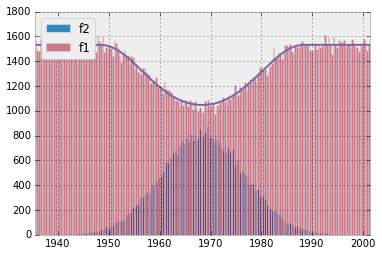

In [13]:
from scipy import stats
B = 200
support = np.linspace(xmin, xmax, B)
plt.hist(Dsignal, bins=B, label='f2')
plt.hist(Dbackground, bins=B, label='f1',alpha=0.5)
plt.plot(support,Range/B * N1*f_f1(support))
plt.legend(loc='upper left')
plt.gca().set_xlim((xmin, xmax));

compute weights of the simulated decay and background events

In [14]:
Vinv = 0
y = np.concatenate((Dbackground, Dsignal))
f1 = f_f1(y)
f2 = stats.norm(D_mean, D_std).pdf(y)

In [15]:
Z = N1 * f1 + N2 * f2
Z.shape,f1.shape,f2.shape

((322942,), (322942,), (322942,))

In [16]:
Vinv = np.array([[f1/Z * f1/Z, f1/Z * f2/Z],[f1/Z * f2/Z, f2/Z*f2/Z]]).sum(axis=-1)

In [17]:
V = np.linalg.inv(Vinv)
V

array([[ 447277.39773022, -172968.11093382],
       [-172968.11093382,  221600.99413516]])

In [18]:
sW = np.dot(V, np.array([f1, f2])) / Z
sW.shape

(2, 322942)

generate a histogram of the decay weights from the simulated decay and background events and compare it with the histogram the weights given by the admin 

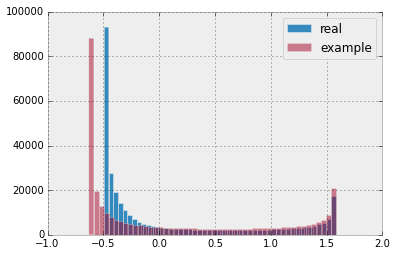

In [19]:
agreement_real.weight.hist(bins=50, label='real')
plt.hist(sW[1,:], label='example',bins=50,alpha=0.5)
plt.legend(loc='upper right')

compute the sPlot weights from f1 and f2 for signal and background over a range of linear spacing (support) of masses

In [20]:
N_support = len(support)
f1_support = f_f1(support)
f2_support = stats.norm(D_mean, D_std).pdf(support)

In [21]:
Z_support = N1 * f1_support + N2 * f2_support
Z_support.shape

(200,)

In [22]:
sW_support = np.dot(V, np.array([f1_support, f2_support])) / Z_support
sW_support.shape

(2, 200)

(1935.44, 2001.304)

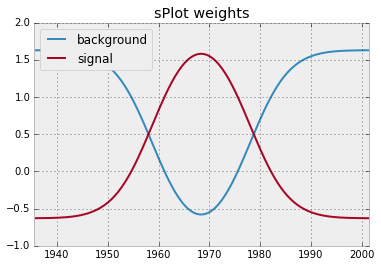

In [23]:
plt.plot(support,sW_support[0,:], label='background')
plt.plot(support,sW_support[1,:], label='signal')
plt.legend(loc='upper left')
plt.title('sPlot weights')
plt.gca().set_xlim((xmin, xmax))